This notebook is associated with Assignment 1. Use it to complete the assignment by following the instructions provided in each section, which includes a text cell describing the requirements. For additional details, see the Canvas.

Use this first cell to import the necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# 1. **Data Management**


In this part, you need to:

1.   analyse and prepare the data. Use plots, graphs, and tables (such as histogram, box plots, scatterplots etc.) to better analyse the dataset and identify issues or potential improvements in the data, including (but not limited to) unnecessary feature/variable which can be dropped/removed, standardization, encoding, etc;
2.   split the data and define your experimental protocol (such as cross-validation or k-fold).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

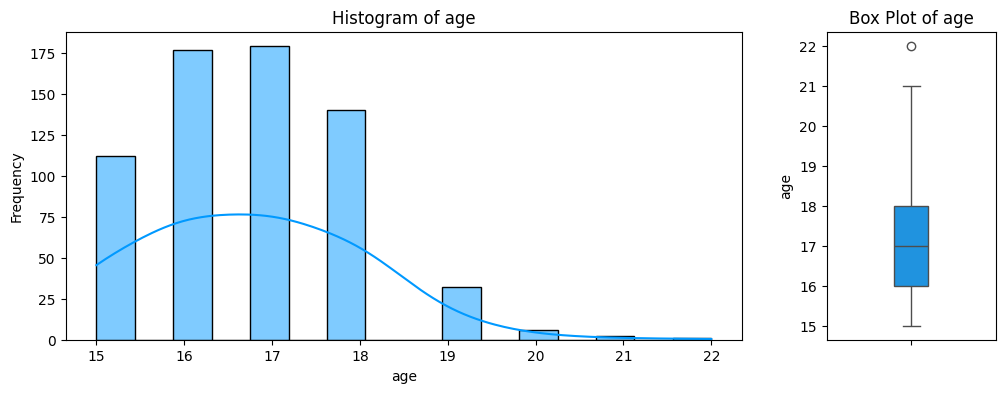

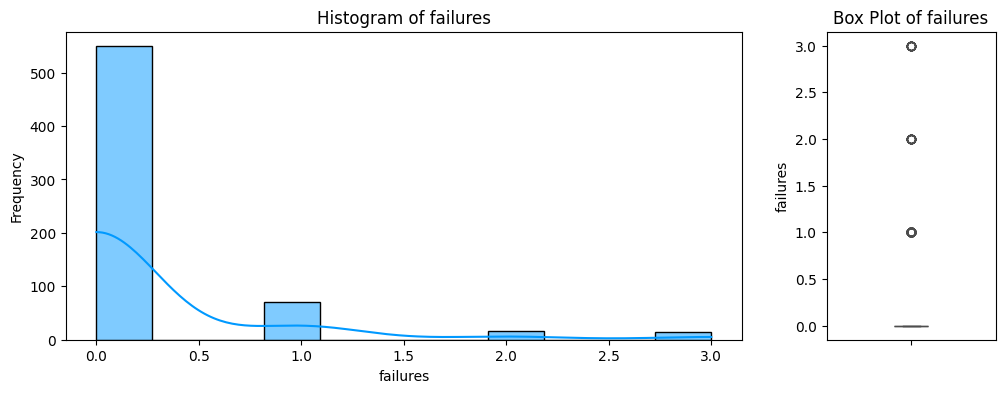

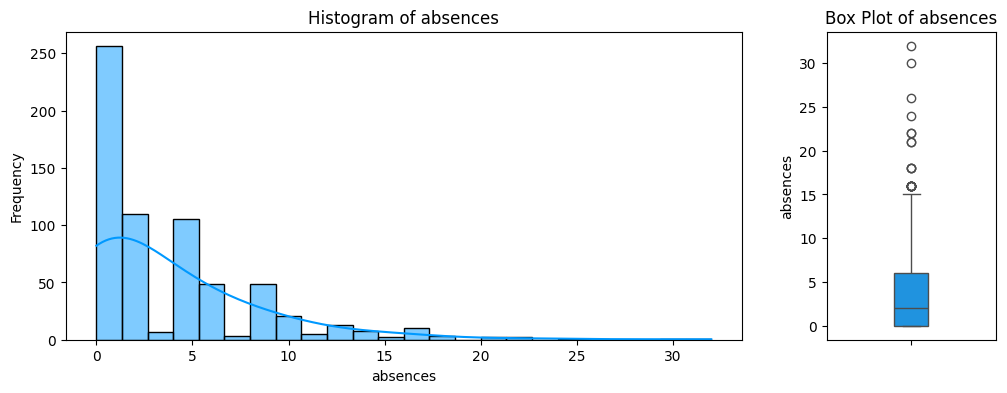

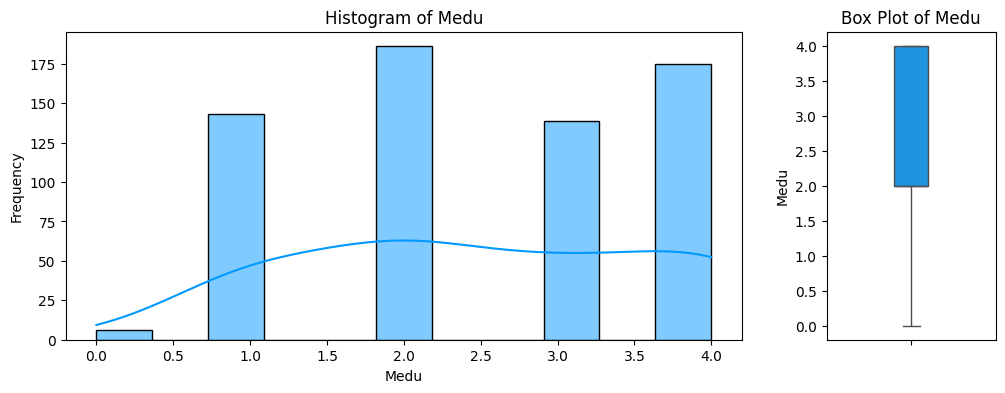

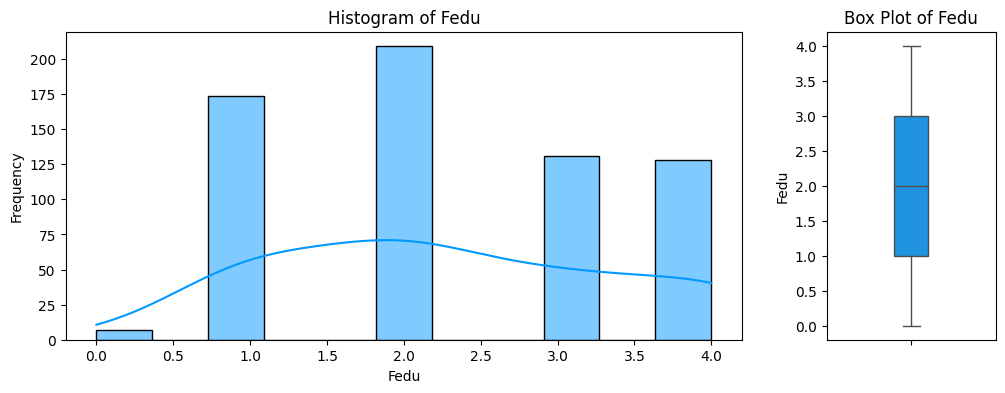

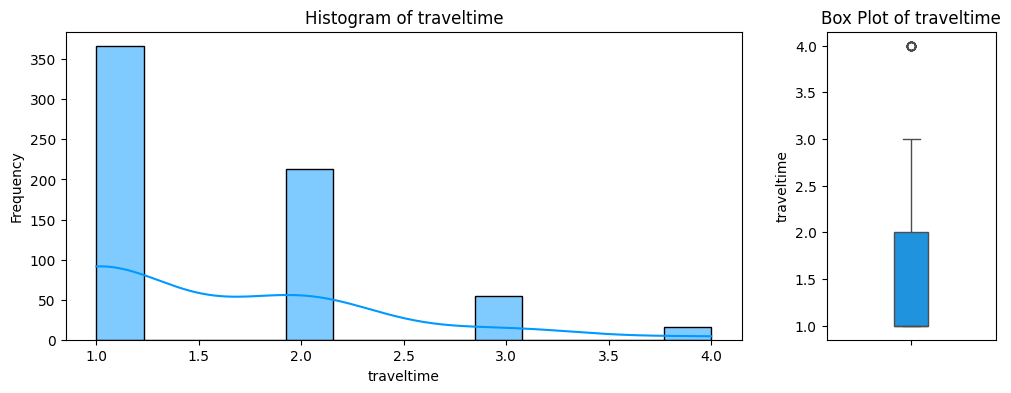

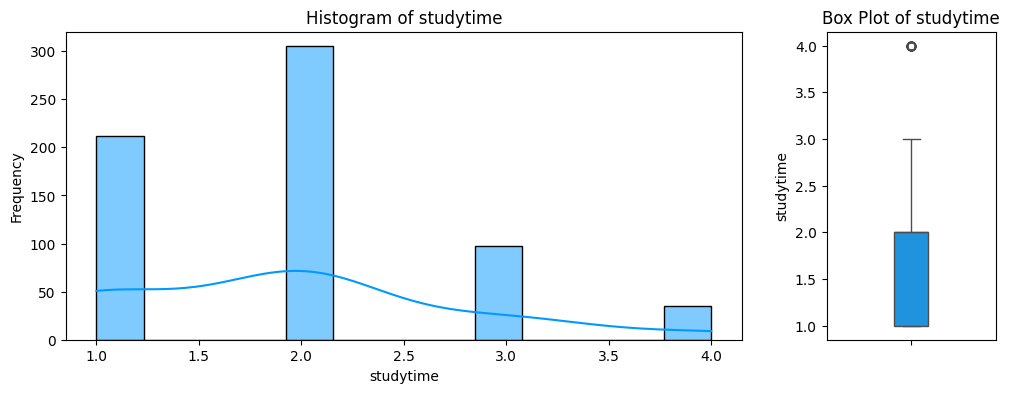

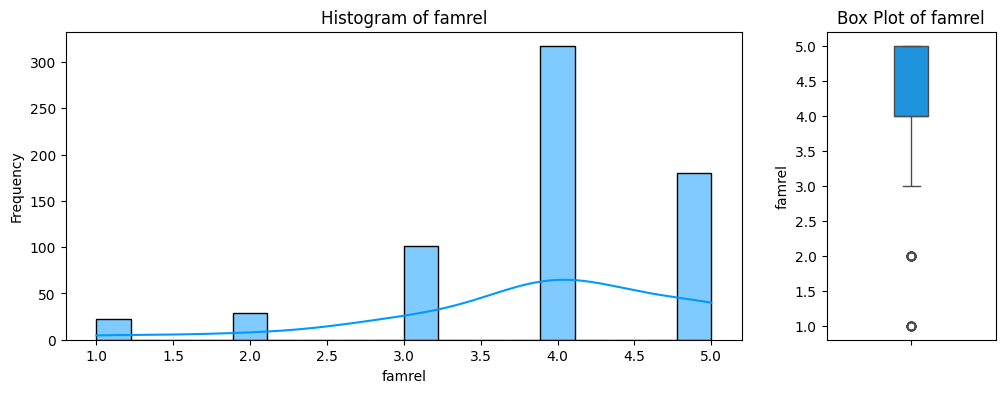

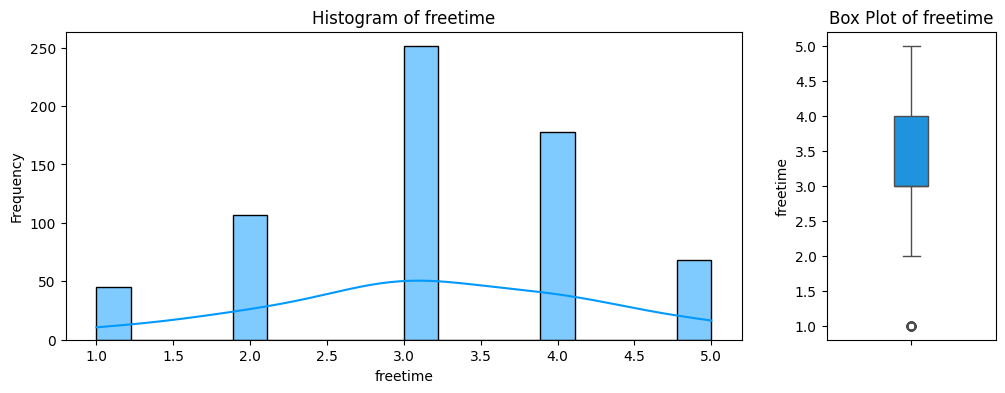

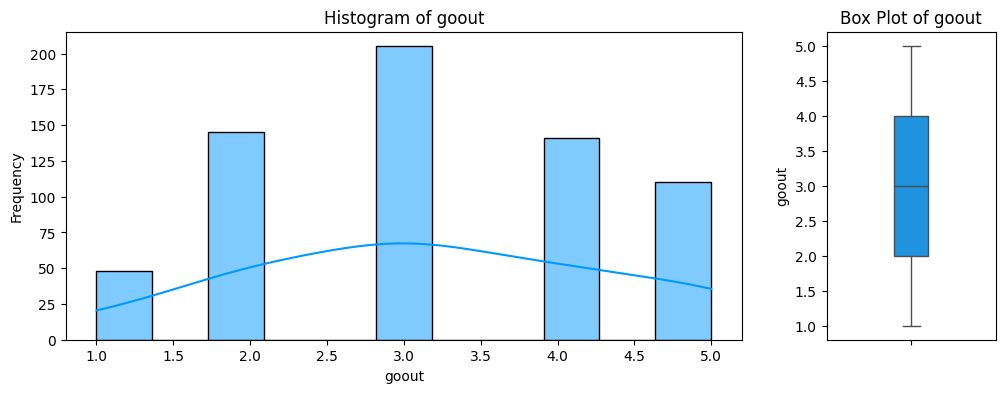

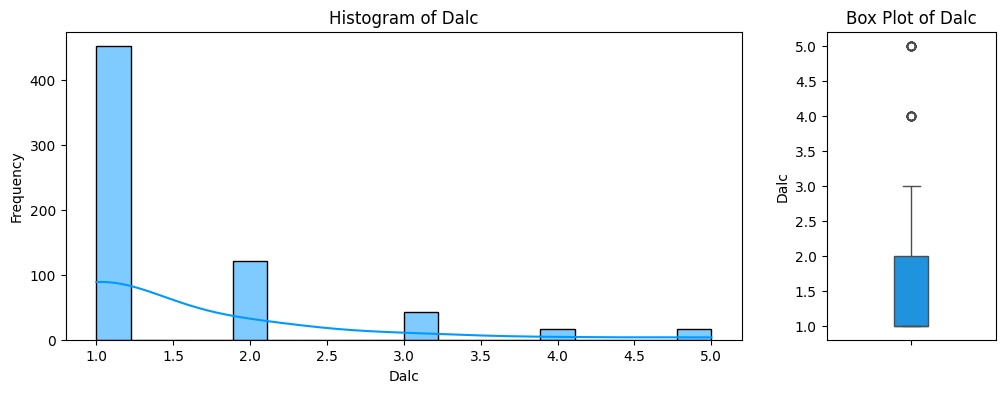

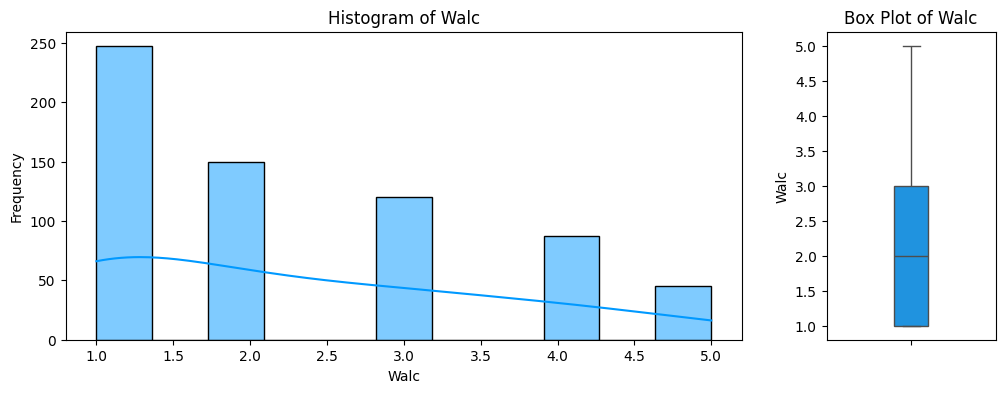

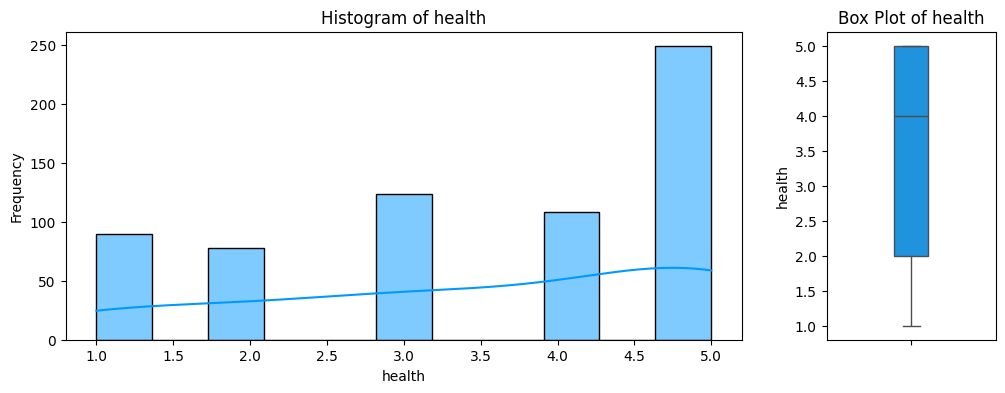


Removing outliers...
Outliers removed, new dataset size: 495 rows (removed 154 rows).



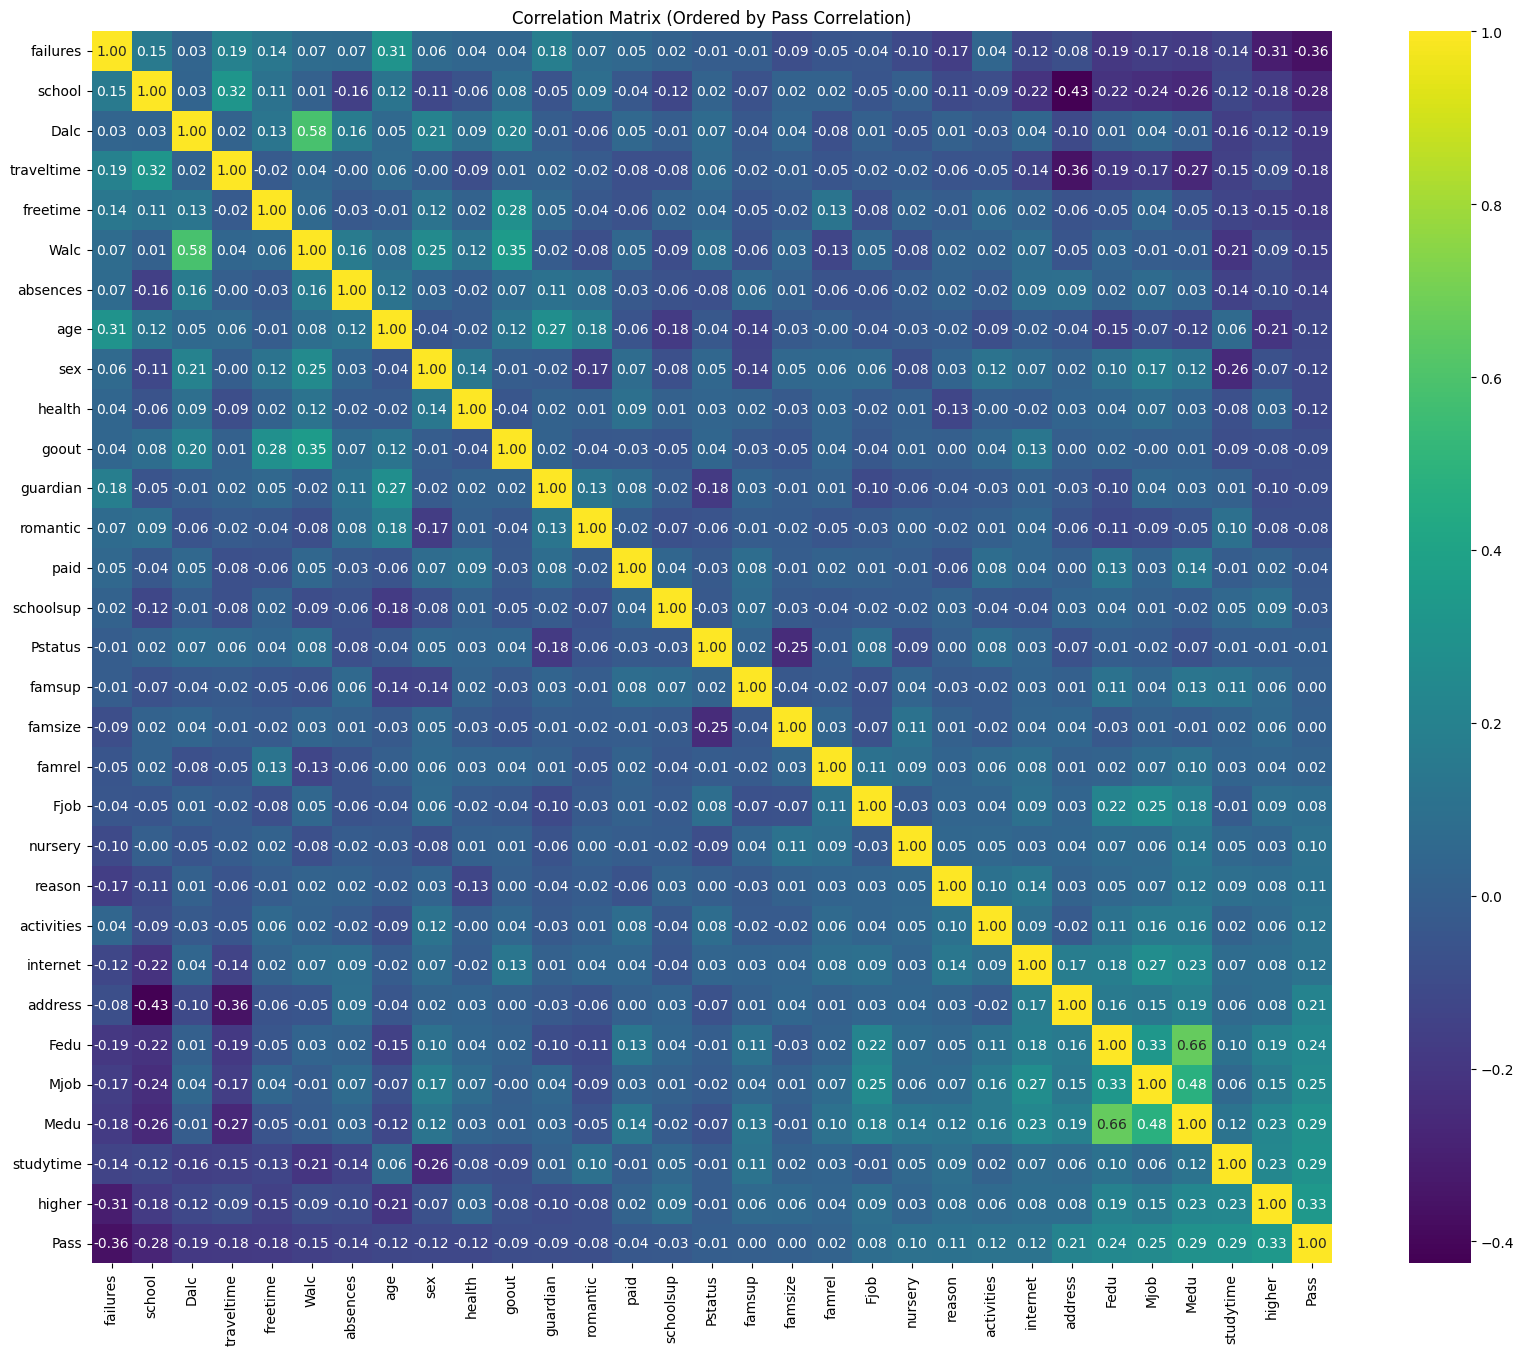


Removing weakly correlated features...
Excluded Columns due to Weak Correlation: ['sex', 'age', 'famsize', 'Pstatus', 'Fjob', 'reason', 'guardian', 'traveltime', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Splitting dataset into training and testing sets...



In [ ]:
# LOADING THE DATA

df = pd.read_csv('assign1-grades.csv')
numerical_cols = ["age", "failures", "absences"]
ordinal_cols = ["Medu", "Fedu", "traveltime", "studytime", "famrel", "freetime", "goout", "Dalc", "Walc", "health"]
nominal_cols = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]
df['Pass'] = (df['Grade'] >= 12).astype(int)
df = df.drop(columns=['Grade'])
df.info()
df.head()
df.describe()

# CHECKING FOR NULL VALUES

missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    print("")
else:
    print("No missing values found.\n")

# ENCODING DATA

encoder = LabelEncoder()
for col in nominal_cols:
    df[col] = encoder.fit_transform(df[col])

# FINDING AND REMOVING OUTLIERS

ignore_outlier_cols = ["failures"]

print("Visualizing outliers...")

numor_cols = numerical_cols + ordinal_cols

for col in numor_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), width_ratios=[4, 1])
    plt.subplot(1, 2, 1)
    # HISTOGRAM PLOT
    sns.histplot(data=df[col], kde=True, color='#0099ff', kde_kws={'bw_method': 0.5}) 
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.subplot(1, 2, 2)
    # BOXPLOT PLOT
    sns.boxplot(data=df[col], color='#0099ff', width=0.2)
    plt.title(f'Box Plot of {col}')
    plt.show()

print("\nRemoving outliers...")

original_shape = df.shape[0]

for col in numerical_cols + ordinal_cols:
    if col not in ignore_outlier_cols:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
print(f"Outliers removed, new dataset size: {df.shape[0]} rows (removed {original_shape - df.shape[0]} rows).\n")
df = df.reset_index(drop=True)

# SCALING NUMERICAL DATA

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# CHECKING CORRELATION AND DROPPING FEATURES

corr_matrix = df.corr()
corr_order = corr_matrix["Pass"].sort_values().index
corr_matrix_sorted = corr_matrix.loc[corr_order, corr_order]

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_sorted, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix (Ordered by Pass Correlation)")
plt.show()
print("")

print("Removing weakly correlated features...")
corr_series = df.corr()["Pass"].drop("Pass")
threshold = 0.2
relevant_cols = ["Pass"] + list(corr_series[abs(corr_series) > threshold].index)
excluded_cols = list(corr_series[abs(corr_series) <= threshold].index)
print("Excluded Columns due to Weak Correlation:", excluded_cols)
df = df[relevant_cols]

# RANDOMIZING AND SPLITTING THE DATA

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Splitting dataset into training and testing sets...\n")
X = df.drop("Pass", axis=1)
y = df["Pass"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kf = KFold(n_splits=10, shuffle=True, random_state=42)




---

# 2. **Model Training**

Here, you need to:

1.	select and compare at least three machine learning models (seen/discussed during the lectures) appropriate for your modelling;
2.	if there are hyperparameters in a selected algorithm, define a hyperparameter search protocol (you can define your own), and tune them.


In [4]:
models = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 150, 200, 250, 300],
            "max_depth": [3, 5, 7, 9, 11, None]
        },
        "results": {"accuracy": 0, "best_params": {}},
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [5, 7, 9, 11],
            "weights": ["uniform", "distance"],
            "p": [1, 2]
        },
        "results": {"accuracy": 0, "best_params": {}},
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=2000, random_state=42),
        "param_grid": {
            "C": [0.1, 0.5, 1, 5, 10],
            "solver": ["liblinear", "lbfgs", "saga"]
        },
        "results": {"accuracy": 0, "best_params": {}},
    }
}

# HYPERPARAMETER TUNING

for model_name, model_data in models.items():
    print(f"\nTraining {model_name}...")

    grid_search = GridSearchCV(
        model_data["model"],
        model_data["param_grid"],
        cv=kf,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    
    models[model_name]["results"]["accuracy"] = grid_search.best_score_
    models[model_name]["results"]["best_params"] = grid_search.best_params_

    print(f"{model_name} Best Params: {grid_search.best_params_}")
    print(f"{model_name} Best Accuracy: {grid_search.best_score_:.4f}")

model_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for model_name, model_data in models.items():
    model_names.append(model_name)
    accuracy_scores.append(model_data["results"]["accuracy"])

    best_model = model_data["model"].set_params(**model_data["results"]["best_params"])
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

results_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

print("")
print(results_df)

best_model_name = max(models, key=lambda k: models[k]["results"]["accuracy"])
best_accuracy = models[best_model_name]["results"]["accuracy"]
best_params = models[best_model_name]["results"]["best_params"]

print(f"\nThe best model is {best_model_name} with an accuracy of {best_accuracy:.4f} and best parameters: {best_params}")



Training Random Forest...
Random Forest Best Params: {'max_depth': 3, 'n_estimators': 200}
Random Forest Best Accuracy: 0.7502

Training KNN...
KNN Best Params: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
KNN Best Accuracy: 0.7247

Training Logistic Regression...
Logistic Regression Best Params: {'C': 1, 'solver': 'lbfgs'}
Logistic Regression Best Accuracy: 0.7575

                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.750192   0.791667  0.904762  0.844444
1                  KNN  0.724744   0.753623  0.825397  0.787879
2  Logistic Regression  0.757500   0.841270  0.841270  0.841270

The best model is Logistic Regression with an accuracy of 0.7575 and best parameters: {'C': 1, 'solver': 'lbfgs'}


---

# 3. **Evaluate models**

Here, you need to:

1.	test the model (the best one you obtained from the above stage) on the testing dataset.



Test accuracy of the best model (Logistic Regression): 0.7980
Test precision of the best model (Logistic Regression): 0.8413
Test recall of the best model (Logistic Regression): 0.8413
Test F1 Score of the best model (Logistic Regression): 0.8413


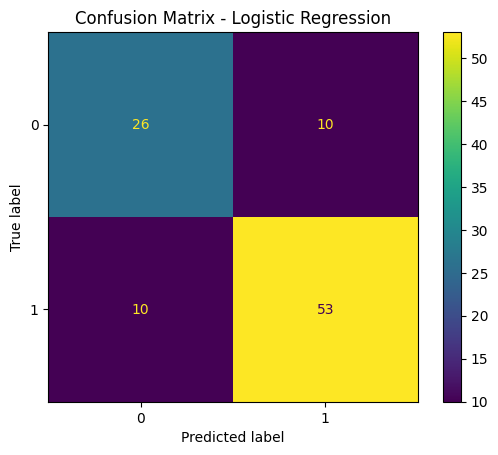

In [6]:
best_model_instance = models[best_model_name]["model"].set_params(**best_params)

best_model_instance.fit(X_train, y_train)
y_pred = best_model_instance.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"\nTest accuracy of the best model ({best_model_name}): {test_accuracy:.4f}")
print(f"Test precision of the best model ({best_model_name}): {test_precision:.4f}")
print(f"Test recall of the best model ({best_model_name}): {test_recall:.4f}")
print(f"Test F1 Score of the best model ({best_model_name}): {test_f1:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()